# **Trong phần này sẽ hướng dẫn train một model theo cách dán nhãn giống với data CIFAR-100**

# *Khai báo một số thư viện cần sử dụng để train với bộ data*

In [2]:
import os
import cv2
import tarfile
import glob
import numpy as np
import matplotlib.pyplot as plt

import tensorflow.keras as keras
import keras.backend as K
from keras.datasets import cifar100
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical, Sequence

import albumentations as albu
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

In [3]:
# set up input size and shape before training
height = 224
width = 224
channels = 3
input_shape = (height, width, channels)
n_classes = 100

# parameters for optimizers
lr = 1e-3

# Parameters for training
epochs = 5
batch_size = 8

# parameters for callback functions
es_patience = 10
rlrop_patience = 5
decay_rate = 0.5

# **Dowload CIFAR-100 Dataset**

- I dowloaded cifar-100 datasets from `keras.datasets`, another way you can download and design of data mannually at https://s3.amazonaws.com/fast-ai-imageclas/cifar100.tgz
- CIFAR-100 contains 50,000 training data and 10,000 testing data each of which is 32 x 32 x 3 images with 1 class out of 100 classes.

In [4]:
# Load available dataset by library 
(X, y), (X_test, y_test) = cifar100.load_data()

print("The shape of X_train : ", X.shape)
print("The shape of X_test : ", X_test.shape)

# Order of classes to use one-hot-encoding 
fine_label_list =  ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 
                    'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
                    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 
                    'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 
                    'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter',
                    'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 
                    'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 
                    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 
                    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'] 

169001437/169001437 [==============================] - 18s 0us/step
The shape of X_train :  (50000, 32, 32, 3)
The shape of X_test :  (10000, 32, 32, 3)


**Plotting some sampled images from randomly chosen 5 classes**

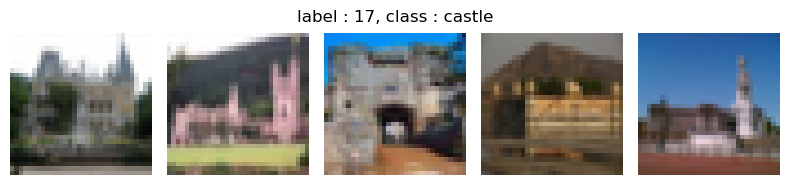

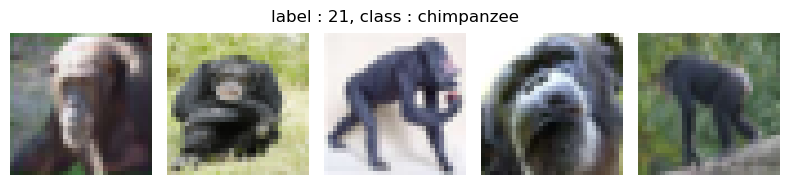

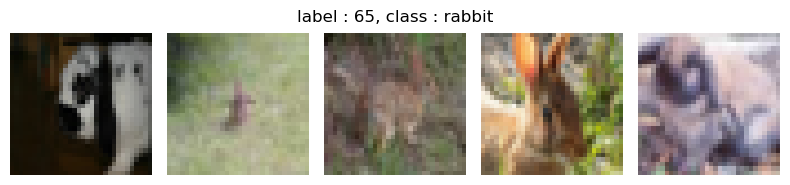

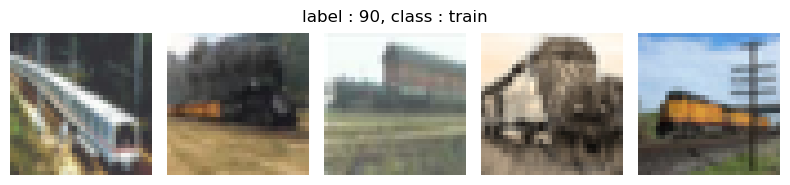

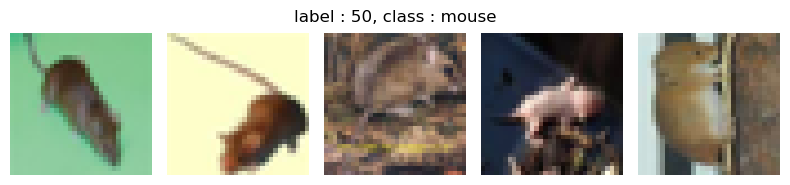

In [5]:
class_plotted = np.random.choice(range(n_classes), 5, replace = False)
for i in range(len(class_plotted)):
    image_samples = X[y.reshape(-1) == class_plotted[i]][:5]
    fig, ax = plt.subplots(nrows = 1, ncols = 5,figsize = (8,8))
    fig.suptitle("label : %d, class : %s" % (class_plotted[i], fine_label_list[class_plotted[i]]), y = .6)
    for j in range(5):
        ax[j].imshow(image_samples[j])
        ax[j].axis('off')  
    fig.tight_layout()
plt.show()

# **Data Preparation**


- Original images should be resized to the specified size, which is (224, 224) in the case of EfficientNetB0.
- The bicubic method is a good choice interpolation when upscaling images and it can be implemented by cv2.INTER_CUBIC.
- The performance of the deep learning model usually improves with the addition of more data and `Albumentations library` of python which helped in real-time data augmentation.

#### **Split train/val/test set**

In [6]:
# Spliting the training data into a training data and a validation data.
st = StratifiedShuffleSplit(n_splits = 2, test_size = 0.2, random_state = 1)
for train_index, val_index in st.split(X, y):
    X_train, X_val, y_train, y_val = X[train_index], X[val_index], y[train_index], y[val_index]
    
print("The number of training data : ", X_train.shape[0])
print("The number of validation data : ", X_val.shape[0])

The number of training data :  40000
The number of validation data :  10000


In [7]:
# resize image to specified size for input of model training
def np_resize(img, shape):
    return cv2.resize(img, (shape[1], shape[0]), interpolation = cv2.INTER_CUBIC)

#### **Data Generator**

In [8]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for keras'
    def __init__(self, images , labels = None, mode = 'fit', batch_size = batch_size,
                 dim = (height, width), channels = channels, n_classes = n_classes,
                 shuffle = True, augment = False):
        self.images = images
        self.labels = labels
        self.mode = mode
        self.batch_size = batch_size
        self.dim = dim
        self.channels = channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        
        self.on_epoch_end()
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.images.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images) / self.batch_size))
        
    def __getitem__(self, index):
        'Generate one batch of data'
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate mini-batch of X
        X = np.empty((self.batch_size, *self.dim, self.channels))
        for i, ID in enumerate(batch_indexes):
            # Generate a preprocessed image
            img = self.images[ID]
            img = img.astype(np.float32) / 255.
            img = np_resize(img, self.dim)
            X[i] = img
            
        
        # Generate mini-batch of y
        if self.mode == 'fit':
            y = self.labels[batch_indexes]
            y = to_categorical(y, n_classes)
            '''
            y = np.zeros((self.batch_size, self.n_classes), dtype = np.uint8)
            for i, ID in enumerate(batch_indexes):
                # one hot encoded label
                y[i, self.labels[ID]] = 1
            '''
            # Augmentation should only be implemented in the training part.
            if self.augment == True:
                X = self.__augment_batch(X)                
            
            return X,y
        
        elif self.mode == 'predict':
            return X       
        
        else:
            raise AttributeError('The mode parameters should be set to "fit" or "predict"')

    # Augmented data by compose transformations       
    def __random_transform(self, img):
        composition = albu.Compose([albu.HorizontalFlip(p = 0.5),
                                    albu.VerticalFlip(p = 0.5),
                                    albu.GridDistortion(p = 0.2),
                                    albu.ElasticTransform(p = 0.2)])
        
        return composition(image = img)['image']
        
    
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i] = self.__random_transform(img_batch[i])
            
        return img_batch

Create Train, Val data generatore, 

In [9]:
train_generator = DataGenerator(X_train, y_train, augment = True)
valid_generator = DataGenerator(X_val, y_val, augment = False)

## **Design Model**

- I used pre-trained model EfficientNetB0 (base model is MobileNet)
- Idea EfficientNet Model: choose base model (MobileNet, ResNet,...), using `Model Scaling methods` to improve accuracy and decrease FLOPs
- The paper EfficientNet says balancing model scaling all dimension model's depth, model's width and resolution of input images is important and will improve the accuracy.

In [10]:
!pip install -U efficientnet

In [16]:
import efficientnet.keras as efn

efnb0 = efn.EfficientNetB0(weights='imagenet', include_top = False, classes = n_classes, input_shape = input_shape)
model = Sequential()
model.add(efnb0)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(n_classes, activation = 'softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 7, 7, 1280)       4049564   
 )                                                               
                                                                 
 global_average_pooling2d_5   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 1280)              0         
                                                                 
 dense_5 (Dense)             (None, 100)               128100    
                                                                 
Total params: 4,177,664
Trainable params: 4,135,648
Non-trainable params: 42,016
_________________________________________________________________


In [17]:
sgd = SGD(lr = lr, momentum = 0.9, nesterov = True)

# early stopping to monitor the validation loss and avoid overfitting
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = es_patience, restore_best_weights = True, verbose = 1)

# reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = rlrop_patience, 
                        factor = decay_rate, min_lr = 1e-6, verbose = 1)
# compile model
model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['acc'])

c:\Users\HP\anaconda3\envs\py37\lib\site-packages\keras\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [18]:
hist = model.fit_generator(train_generator,validation_data = valid_generator, 
                           epochs = epochs, verbose = 1, callbacks = [es, rlrop])

model.save_weights("best_weight.h5")

c:\Users\HP\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/5
5000/5000 [==============================] - 5037s 1s/step - loss: 2.8890 - acc: 0.3096 - val_loss: 1.2048 - val_acc: 0.6491 - lr: 0.0010
Epoch 2/5
5000/5000 [==============================] - 4726s 945ms/step - loss: 1.7092 - acc: 0.5351 - val_loss: 0.9079 - val_acc: 0.7276 - lr: 0.0010
Epoch 3/5
5000/5000 [==============================] - 4548s 910ms/step - loss: 1.4125 - acc: 0.6060 - val_loss: 0.8324 - val_acc: 0.7527 - lr: 0.0010
Epoch 4/5
5000/5000 [==============================] - 4653s 931ms/step - loss: 1.2483 - acc: 0.6478 - val_loss: 0.7705 - val_acc: 0.7746 - lr: 0.0010
Epoch 5/5
5000/5000 [==============================] - 4871s 974ms/step - loss: 1.1291 - acc: 0.6788 - val_loss: 0.7257 - val_acc: 0.7826 - lr: 0.0010


**Plot accuracy and loss function**

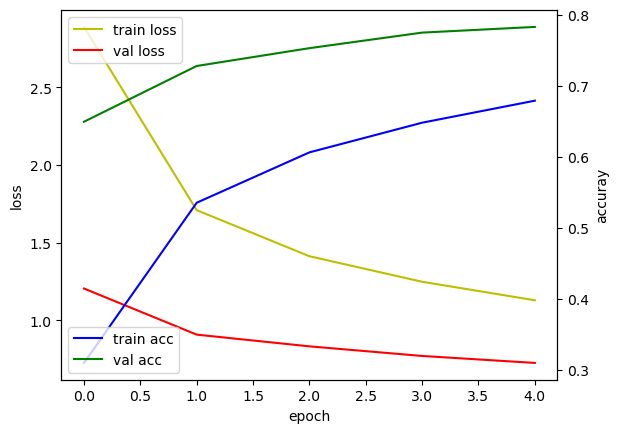

In [19]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

### **Save model**

In [24]:
model.save('efficientnetb0.h5')

# **Inference**

**Load model** 

In [25]:
reconstructed_model = load_model('C:\\Users\\HP\\Desktop\\prj\\efficientnetb0.h5')

**Retrain model**

# **Evaluate Model**

#### **Validation accuracy**

In [28]:
print("The Accuracy on the validation data : {:.2f}%".format(100 * reconstructed_model.evaluate(valid_generator, verbose = 1)[-1]))

1250/1250 [==============================] - 277s 220ms/step - loss: 0.7450 - acc: 0.7765
The Accuracy on the validation data : 77.65%


#### **Test accuracy**

In [30]:
test_generator = DataGenerator(X_test, mode = 'predict', augment = False, shuffle = False)
y_pred = reconstructed_model.predict(test_generator,verbose = 1)
y_pred = np.argmax(y_pred, axis = 1)

print("The accuracy on the testing data : {:.2f}%".format(100 * accuracy_score(y_test, y_pred)))

1250/1250 [==============================] - 277s 220ms/step
The accuracy on the testing data : 78.22%


# **Make Predictions**

**Load model to make predictions**

In [31]:
from urllib.request import urlopen
from PIL import Image
import requests
import numpy as np
import cv2

# we make predictions from list urls of images, and model we already trained
def make_prediction(urls, model):
  imgs = np.empty((len(urls), *(224,224), 3))
  for i, url in enumerate(urls):
    img = Image.open(urlopen(url))
    img = np.asarray(img)
    img = img.astype(np.float32) / 255.
    img = np_resize(img, (224,224))
    imgs[i] = img
  predictions = model.predict(imgs)
  predictions = np.argmax(predictions, axis = 1)
  classes = [fine_label_list[i] for i in predictions] 
  return imgs, classes

# show prediction result of model
def show_pred_result(urls, model):
  imgs, classes = make_prediction(urls, model)
  n_cols = 3
  n_rows = int(np.ceil(len(urls)/3))
  _, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))   
  axs = axs.flatten()
  i = 0
  for img, ax in zip(imgs, axs):
    ax.imshow(img)
    ax.set_title(classes[i])
    i = i+1
  plt.show()

In [32]:
import os
import cv2
import tarfile
import glob
import numpy as np
import matplotlib.pyplot as plt

import tensorflow.keras as keras
import keras.backend as K
from keras.datasets import cifar100
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical, Sequence

import albumentations as albu
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

**Load model to predict image classes**

In [33]:
new_model = load_model('efficientnetb0.h5')

# Get images from links on internet
urls = ['https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSdrJVast22-PGuW3WGSy3DH6YbWKg9us0gAA&usqp=CAU', 'https://vnn-imgs-a1.vgcloud.vn/icdn.dantri.com.vn/2021/05/26/ngo-ngang-voi-ve-dep-cua-hot-girl-anh-the-chua-tron-18-docx-1622043349706.jpeg',
        'https://ggsc.s3.amazonaws.com/images/uploads/The_Science-Backed_Benefits_of_Being_a_Dog_Owner.jpg', 'https://static.seekingalpha.com/cdn/s3/uploads/getty_images/1344443930/image_1344443930.jpg',
        'https://i.natgeofe.com/n/9b87dda3-9946-4a1c-a97f-c21f73ced888/Meraxes-CREDIT-Carlos-Papolio_4x3.jpg','https://cdn.shopify.com/s/files/1/0059/8835/2052/products/Austian_Pine_Tree_7_FGT_650x.jpg']

1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


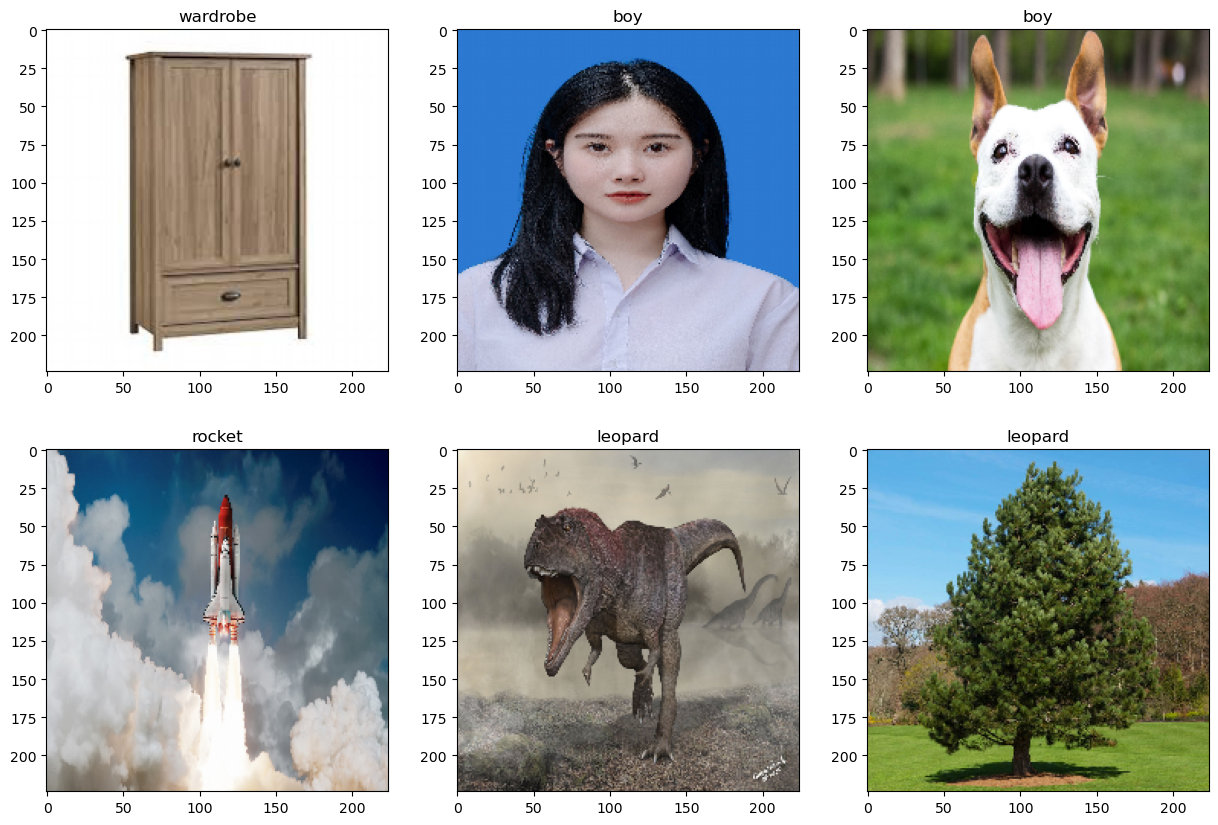

In [34]:
show_pred_result(urls, new_model)